# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# tf.random.set_seed(30)
tf.set_random_seed(30)

Using TensorFlow backend.


In [3]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images))
    f.set_figwidth(15)
    for ax,image,caption in zip(axes, images, captions):
        ax.imshow(image, cmap)
        ax.set_title(caption)

In [4]:
# define the path where training and validation data are placed.
SOURCE_PATH = os.getcwd()

# Training data constants
TRAIN_DATA_PATH = SOURCE_PATH + '/Project_data/train'
TRAIN_DATA_CSV = SOURCE_PATH + '/Project_data/train.csv'

# Validation data constants
VALIDATION_DATA_PATH = SOURCE_PATH + '/Project_data/val'
VALIDATION_DATA_CSV = SOURCE_PATH + '/Project_data/val.csv'

NUM_CLASSES = 5

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
TRAIN_DOC = np.random.permutation(open(TRAIN_DATA_CSV).readlines())
VALIDATION_DOC = np.random.permutation(open(VALIDATION_DATA_CSV).readlines())

print("Training data size = {}".format(len(TRAIN_DOC)))
print("Validation data size = {}".format(len(VALIDATION_DOC)))

Training data size = 663
Validation data size = 100


---
### Choosing Frame Dimenstion:

- Lets visualize 360x360 and 120x160 image in different dimension as below:
    - 360x360
    - 240x240
    - 120x120

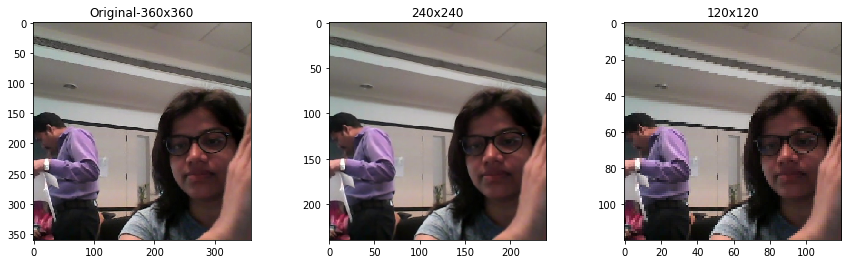

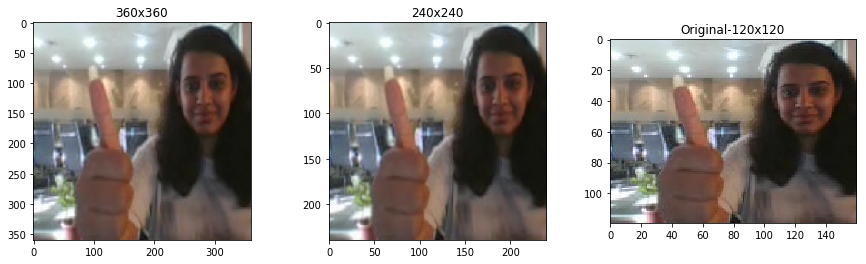

In [6]:
# below is 360x360 image frame
largeSizeImage = cv2.cvtColor(
    cv2.imread(
        TRAIN_DATA_PATH + '/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png'),
    cv2.COLOR_BGR2RGB)

# below is 120x160 image frame
smallSizeImage = cv2.cvtColor(
    cv2.imread(
        TRAIN_DATA_PATH + '/WIN_20180925_17_22_11_Pro_Thumbs_Up_new/WIN_20180925_17_22_11_Pro_00041.png'),
    cv2.COLOR_BGR2RGB)

# resize of 360x360 image and plot
largeSizeImageResizeTo120 = cv2.resize(largeSizeImage, (120, 120))
largeSizeImageResizeTo240 = cv2.resize(largeSizeImage, (240, 240))
plot_image([largeSizeImage, largeSizeImageResizeTo240, largeSizeImageResizeTo120],
           captions = ["Original-360x360", "240x240", "120x120" ])

# resize of 120x160 image and plot
smallSizeImageResizeTo320 = cv2.resize(smallSizeImage, (360, 360))
smallSizeImageResizeTo240 = cv2.resize(smallSizeImage, (240, 240))
plot_image([smallSizeImageResizeTo320, smallSizeImageResizeTo240, smallSizeImage ],
           captions = ["360x360", "240x240" , "Original-120x120"])

- 240x240 dimension image seems to be good options in terms of picture clarity. Hence we would be resizing all the images to this.

In [7]:
VIDEO_FRAME_COUNT = 30
CLASS_COUNT = 5
FRAME_RESIZE_DIMENSION = (120, 120)
FRAME_RESIZE_CROP_DIMENSION = (80, 80)

---

### Possible Augmentations:
`Flipping`: `No`
- Up-down flip of frame will not be helpful
- Left-Right flip incase of fast forward or backward will consfuse the model


`Rotation` : `No`
- Rotating to certain angle is quite possible, but we would prefer no to use as data would already have certain degree of rotation.

`Cropping` : `No`
- Certain User actions like fast forward and backward, certain frames are around the edges. Hence good to avoid.

`Scaling` : `Yes`
- We are using this for resizing the image to common dimenstion(240x240) and can be feeded to model.

`Translation` : `No`
- With given problem statement, translating the frames may break the sequence of action which model actually needs to learn. 

In [8]:
class FrameProcessing():
    
    def __init__(self, path):
        """
            When the image file is read with the OpenCV function imread(), the order of colors is BGR.
            Hence changing it to RGB
        """
        self.image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    def get(self):
        """get the image array"""
        return self.image
    
    def resize(self):
        """ resize the image to 120x120 """
        self.image = cv2.resize(self.image, FRAME_RESIZE_DIMENSION, interpolation=cv2.INTER_AREA)
        return self
    
    def crop (self):
        """crop the image"""
        self.image = self.image[20:100, 20:100]
        return self;
    
    def normalization(self):
        """normalize the image by dividing by 255"""
        self.image = self.image/255
        return self
        

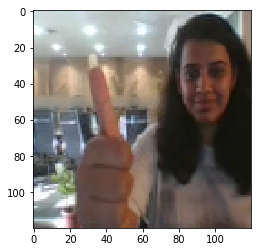

In [9]:
# Lets visualize an image
img = FrameProcessing(
    TRAIN_DATA_PATH + '/WIN_20180925_17_22_11_Pro_Thumbs_Up_new/WIN_20180925_17_22_11_Pro_00041.png').resize()
plt.imshow(img.get())

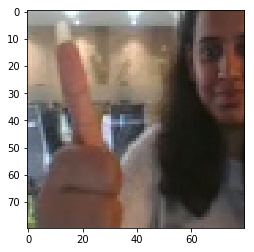

In [10]:
plt.imshow(img.crop().get())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
def generator(source_path, folder_list, batch_size, crop=False):
    img_idx = list(range(0, VIDEO_FRAME_COUNT, 1))
    while True:
        t = np.random.permutation(folder_list)

        num_batches = len(t)//batch_size
        for batch in range(num_batches):
            if crop == True:
                batch_data = np.zeros((batch_size,
                                       VIDEO_FRAME_COUNT,FRAME_RESIZE_CROP_DIMENSION[0],FRAME_RESIZE_CROP_DIMENSION[1],3))
            else:
                batch_data = np.zeros((batch_size,
                                       VIDEO_FRAME_COUNT,FRAME_RESIZE_DIMENSION[0],FRAME_RESIZE_DIMENSION[1],3))

            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):                    
                    imageObj = FrameProcessing(
                        source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])

                    # just performing resize as discussed above
                    imageObj.resize()
                    if crop == True:
                        imageObj.crop()
                    imageObj.normalization()
                    
                    batch_data[folder,idx,:,:,0] = imageObj.get()[:,:,0]
                    batch_data[folder,idx,:,:,1] = imageObj.get()[:,:,1]
                    batch_data[folder,idx,:,:,2] = imageObj.get()[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

        
        # remaining data points which are left after full batches
        remaining_folder = len(t)%batch_size
        if (remaining_folder > 0):
            if crop == True:
                batch_data = np.zeros((remaining_folder,
                                       VIDEO_FRAME_COUNT,FRAME_RESIZE_CROP_DIMENSION[0],FRAME_RESIZE_CROP_DIMENSION[1],3))
            else:
                batch_data = np.zeros((remaining_folder,
                                       VIDEO_FRAME_COUNT,FRAME_RESIZE_DIMENSION[0],FRAME_RESIZE_DIMENSION[1],3))
            
            batch_labels = np.zeros((remaining_folder,5))
            for folder in range(0, remaining_folder):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    imageObj = FrameProcessing(
                        source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])

                    # just performing resize as discussed above
                    imageObj.resize()
                    if crop == True:
                        imageObj.crop()
                    imageObj.normalization()

                    batch_data[folder,idx,:,:,0] = imageObj.get()[:,:,0]
                    batch_data[folder,idx,:,:,1] = imageObj.get()[:,:,1]
                    batch_data[folder,idx,:,:,2] = imageObj.get()[:,:,2]
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(TRAIN_DOC)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(VALIDATION_DOC)
print('# Validation sequences =', num_val_sequences)

# Training sequences = 663
# Validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, Dropout, TimeDistributed, Flatten, BatchNormalization, Activation, GlobalAveragePooling3D
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50


def model_callbacks(model_checkpoint_name):
    model_name = model_checkpoint_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    callbacks_list = [checkpoint, LR]
    return callbacks_list

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

---

## Evaluate batch size:

In [14]:
def get_sample_model():
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [15]:
get_sample_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 64)    55360     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 64)    0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 30, 30, 64)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 30, 30, 64)     110656    
__________

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:

# num_epochs = 2

# for batch_size in range (20, 19, -10):
#     print("*********************************************")
#     print("FOR BATCH SIZE :", batch_size)
    
#     try: 
#         train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, batch_size)
#         val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, batch_size)

#         if (num_val_sequences%batch_size) == 0:
#             validation_steps = int(num_val_sequences/batch_size)
#             steps_per_epoch = int(num_train_sequences/batch_size)
#         else:
#             validation_steps = (num_val_sequences//batch_size) + 1
#             steps_per_epoch = (num_train_sequences//batch_size) + 1

#         get_sample_model().fit_generator(train_generator, 
#                                          steps_per_epoch=steps_per_epoch, 
#                                          epochs=num_epochs, 
#                                          verbose=1,
#                                          validation_data=val_generator, 
#                                          validation_steps=validation_steps, 
#                                          class_weight=None, 
#                                          workers=1, 
#                                          initial_epoch=0)
#     except:
#         print("OOM error for Batch size:" , batch_size)
    

In [17]:
BATCH_SIZE = 20;

In [18]:
if (num_train_sequences%BATCH_SIZE) == 0:
    steps_per_epoch = int(num_train_sequences/BATCH_SIZE)
else:
    steps_per_epoch = (num_train_sequences//BATCH_SIZE) + 1

if (num_val_sequences%BATCH_SIZE) == 0:
    validation_steps = int(num_val_sequences/BATCH_SIZE)
else:
    validation_steps = (num_val_sequences//BATCH_SIZE) + 1

--- 

# Model: Conv3D

In [19]:
Conv3DModel = Sequential()
Conv3DModel.add(Conv3D(32, (3, 3, 3), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
Conv3DModel.add(Activation('relu'))
Conv3DModel.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel.add(Activation('relu'))
Conv3DModel.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel.add(Activation('relu'))
Conv3DModel.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel.add(Flatten())
Conv3DModel.add(Dense(64, activation='relu'))
Conv3DModel.add(Dropout(0.25))

Conv3DModel.add(Dense(CLASS_COUNT, activation='softmax'))

optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
Conv3DModel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
Conv3DModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 64)    55360     
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 64)    0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 30, 30, 64)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 30, 30, 64)     110656    
__________

In [20]:
# num_epochs= 10

# train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, BATCH_SIZE)
# val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

# history = Conv3DModel.fit_generator(
#     train_generator, 
#     steps_per_epoch=steps_per_epoch, 
#     epochs=num_epochs, 
#     verbose=1,
#     callbacks=model_callbacks('Conv3DModel'),
#     validation_data=val_generator, 
#     validation_steps=validation_steps, 
#     class_weight=None, 
#     workers=1, 
#     initial_epoch=0)

# plot(history)

---

# Model: Conv3D with cropping

In [29]:
Conv3DModel_With_Crop = Sequential()
Conv3DModel_With_Crop.add(Conv3D(32, (3, 3, 3), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_CROP_DIMENSION[0], FRAME_RESIZE_CROP_DIMENSION[1], 3)))
Conv3DModel_With_Crop.add(Activation('relu'))
Conv3DModel_With_Crop.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_Crop.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_Crop.add(Activation('relu'))
Conv3DModel_With_Crop.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_Crop.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_Crop.add(Activation('relu'))
Conv3DModel_With_Crop.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_Crop.add(Flatten())
Conv3DModel_With_Crop.add(Dense(64, activation='relu'))
Conv3DModel_With_Crop.add(Dropout(0.25))

Conv3DModel_With_Crop.add(Dense(CLASS_COUNT, activation='softmax'))

optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
Conv3DModel_With_Crop.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
Conv3DModel_With_Crop.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 30, 80, 80, 32)    2624      
_________________________________________________________________
activation_20 (Activation)   (None, 30, 80, 80, 32)    0         
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 15, 40, 40, 32)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 15, 40, 40, 64)    55360     
_________________________________________________________________
activation_21 (Activation)   (None, 15, 40, 40, 64)    0         
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 7, 20, 20, 64)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 7, 20, 20, 64)     110656    
__________

In [ ]:
num_epochs= 10

train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, BATCH_SIZE, crop=True)
val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE, crop=True)

history = Conv3DModel_With_Crop.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModel_Cropping'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

Epoch 1/10
34/34 [==============================] - 45s 1s/step - loss: 1.6171 - categorical_accuracy: 0.1634 - val_loss: 1.6094 - val_categorical_accuracy: 0.1600

Epoch 00001: val_categorical_accuracy improved from -inf to 0.16000, saving model to Conv3DModel_Cropping_2020-03-1515_59_20.455081/model-00001-1.61759-0.16742-1.60936-0.16000.h5
Epoch 2/10
 9/34 [======>.......................] - ETA: 27s - loss: 1.5984 - categorical_accuracy: 0.2333

In [23]:
Conv3DModel_With_BN = Sequential()
Conv3DModel_With_BN.add(Conv3D(32, (3, 3, 3), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
Conv3DModel_With_BN.add(Activation('relu'))
Conv3DModel_With_BN.add(BatchNormalization())
Conv3DModel_With_BN.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_BN.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_BN.add(Activation('relu'))
Conv3DModel_With_BN.add(BatchNormalization())
Conv3DModel_With_BN.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_BN.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_BN.add(Activation('relu'))
Conv3DModel_With_BN.add(BatchNormalization())
Conv3DModel_With_BN.add(MaxPooling3D(pool_size=(2, 2, 2)))

Conv3DModel_With_BN.add(Flatten())
Conv3DModel_With_BN.add(Dense(64, activation='relu'))
Conv3DModel_With_BN.add(BatchNormalization())
Conv3DModel_With_BN.add(Dropout(0.25))

Conv3DModel_With_BN.add(Dense(CLASS_COUNT, activation='softmax'))

optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
Conv3DModel_With_BN.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
Conv3DModel_With_BN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_11 (Activation)   (None, 30, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 15, 60, 60, 64)    55360     
_________________________________________________________________
activation_12 (Activation)   (None, 15, 60, 60, 64)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 64)    256       
__________

Epoch 1/10
34/34 [==============================] - 68s 2s/step - loss: 1.4550 - categorical_accuracy: 0.4452 - val_loss: 5.6834 - val_categorical_accuracy: 0.2500

Epoch 00001: val_categorical_accuracy improved from -inf to 0.25000, saving model to Conv3DModel_With_BN_2020-03-1515_59_20.455081/model-00001-1.44837-0.44796-5.68343-0.25000.h5
Epoch 2/10
34/34 [==============================] - 56s 2s/step - loss: 1.0895 - categorical_accuracy: 0.5740 - val_loss: 1.0507 - val_categorical_accuracy: 0.6300

Epoch 00002: val_categorical_accuracy improved from 0.25000 to 0.63000, saving model to Conv3DModel_With_BN_2020-03-1515_59_20.455081/model-00002-1.09886-0.57164-1.05066-0.63000.h5
Epoch 3/10
34/34 [==============================] - 55s 2s/step - loss: 0.8334 - categorical_accuracy: 0.6880 - val_loss: 12.5721 - val_categorical_accuracy: 0.2200

Epoch 00003: val_categorical_accuracy did not improve from 0.63000
Epoch 4/10
34/34 [==============================] - 56s 2s/step - loss: 0.7051

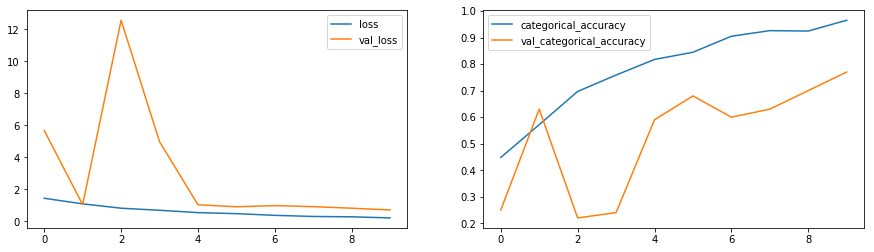

In [24]:
num_epochs= 10

train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, BATCH_SIZE)
val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModel_With_BN.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModel_With_BN'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

In [27]:
Conv3DModel_With_BN_DP = Sequential()
Conv3DModel_With_BN_DP.add(Conv3D(32, (3, 3, 3), padding='same',
                     input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
Conv3DModel_With_BN_DP.add(Activation('relu'))
Conv3DModel_With_BN_DP.add(BatchNormalization())
Conv3DModel_With_BN_DP.add(MaxPooling3D(pool_size=(2, 2, 2)))
Conv3DModel_With_BN_DP.add(Dropout(0.25))

Conv3DModel_With_BN_DP.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_BN_DP.add(Activation('relu'))
Conv3DModel_With_BN_DP.add(BatchNormalization())
Conv3DModel_With_BN_DP.add(MaxPooling3D(pool_size=(2, 2, 2)))
Conv3DModel_With_BN_DP.add(Dropout(0.25))

Conv3DModel_With_BN_DP.add(Conv3D(64, (3, 3, 3), padding='same'))
Conv3DModel_With_BN_DP.add(Activation('relu'))
Conv3DModel_With_BN_DP.add(BatchNormalization())
Conv3DModel_With_BN_DP.add(MaxPooling3D(pool_size=(2, 2, 2)))
Conv3DModel_With_BN_DP.add(Dropout(0.25))

Conv3DModel_With_BN_DP.add(Flatten())
Conv3DModel_With_BN_DP.add(Dense(64, activation='relu'))
Conv3DModel_With_BN_DP.add(BatchNormalization())
Conv3DModel_With_BN_DP.add(Dropout(0.25))

Conv3DModel_With_BN_DP.add(Dense(CLASS_COUNT, activation='softmax'))

optimiser = optimizers.SGD(lr=0.01, decay=1e-6, nesterov=True)
Conv3DModel_With_BN_DP.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
Conv3DModel_With_BN_DP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_17 (Activation)   (None, 30, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 15, 60, 60, 32)    0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 15, 60, 60, 64)    55360     
_________________________________________________________________
activation_18 (Activation)   (None, 15, 60, 60, 64)    0         
__________

Epoch 1/10
34/34 [==============================] - 60s 2s/step - loss: 1.3713 - categorical_accuracy: 0.4614 - val_loss: 2.2080 - val_categorical_accuracy: 0.2200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.22000, saving model to Conv3DModel_With_BN_DP_2020-03-1515_59_20.455081/model-00001-1.36562-0.46456-2.20797-0.22000.h5
Epoch 2/10
34/34 [==============================] - 56s 2s/step - loss: 0.8469 - categorical_accuracy: 0.6637 - val_loss: 3.8544 - val_categorical_accuracy: 0.2100

Epoch 00002: val_categorical_accuracy did not improve from 0.22000
Epoch 3/10
34/34 [==============================] - 56s 2s/step - loss: 0.6814 - categorical_accuracy: 0.7491 - val_loss: 3.5340 - val_categorical_accuracy: 0.2100

Epoch 00003: val_categorical_accuracy did not improve from 0.22000
Epoch 4/10
34/34 [==============================] - 56s 2s/step - loss: 0.5431 - categorical_accuracy: 0.8087 - val_loss: 1.9661 - val_categorical_accuracy: 0.3600

Epoch 00004: val_categori

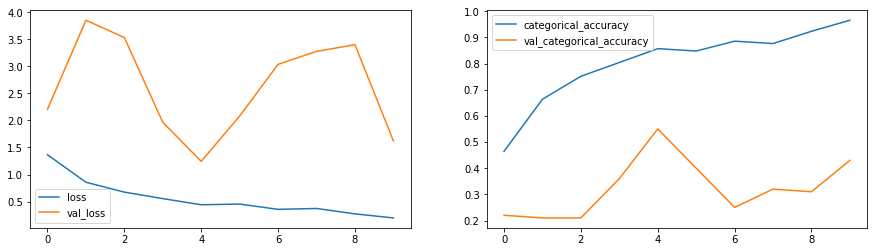

In [28]:
num_epochs= 10

train_generator = generator(TRAIN_DATA_PATH, TRAIN_DOC, BATCH_SIZE)
val_generator = generator(VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModel_With_BN_DP.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModel_With_BN_DP'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)